<a href="https://colab.research.google.com/github/usuario2014/AUTOMATAS/blob/master/20192_M2_855_PEC2_Enunciado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2019-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 1. **Clustering clásico**: k-means y la regla del codo.
 - **Clustering con formas y feature engineering**.
 - **Optimización con reducción de dimensionalidad**: t-SNE.
 - **Aplicación**: agrupación de documentos.
   
Para ello vamos a necesitar las siguientes librerías:

In [0]:
import random

import numpy as np
import pandas as pd
from sklearn import cluster      # Algoritmos de clustering.
from sklearn import datasets     # Crear datasets.
from sklearn import manifold     # Algoritmos de reduccion de dimensionalidad.
from sklearn.cluster import KMeans
# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Clustering clásico: k-means y la regla del codo (2 puntos)

Vamos a partir de un dataset de clientes en un negocio *retail* cualquiera (en el fichero *pec2_1.p* un *DataFrame* de *pandas* en formato *pickle* o *pec2_1.csv* en formato *CSV*).

Para cada cliente se cuenta con 3 variables:
 - **n_days_per_week**: frecuencia de asistencia a la tienda a la semana.
 - **n_month_purchases**: número de compras al mes.
 - **avg_month_turnover**: el gasto medio de un cliente al mes.
 
 Primero se pide visualizar las variables para entender como están distribuidas y preprocesarlas para aplicar un *k-means*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

> Bloc con sangría


<strong>Implementación:</strong> visualizar y preprocesar las variables (para que todas las variables tengan el mismo peso).  
</div>

In [0]:
#Para la lectura de los archivos he 
url="https://glass.artwebserver.net/data_csv/pec2_1.csv"
data=pd.read_csv(url)
data.head()
data.describe

<bound method NDFrame.describe of       avg_month_turnover  n_days_per_week  n_month_purchases
0             108.331434         3.263182           5.523083
1             101.253142         5.197333           5.303098
2              60.900002         3.176871           5.082450
3              90.926811         4.184747           5.272594
4             114.936497         3.335393           4.754987
...                  ...              ...                ...
1195           98.636121         1.596022           1.854474
1196          118.707368         1.315034           0.446943
1197            0.100000         0.100000           0.100000
1198            0.100000         0.100000           0.100000
1199            0.100000         0.100000           0.100000

[1200 rows x 3 columns]>

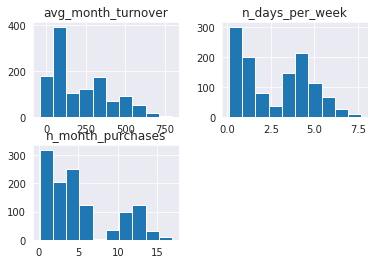

In [0]:
data.hist()
plt.show()

In [0]:
#%% Se eliminan filas que tengan valor NaN.
df = data.dropna()
df = data.reset_index(drop=True)


In [0]:
from sklearn import preprocessing
x = df.values#returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df = df.rename(columns = {0: 'avg_month_turnover', 1: 'n_days_per_week', 2: 'n_month_purchases'})

In [0]:
df

,avg_month_turnover,n_days_per_week,n_month_purchases
0,0.179334,0.417010,0.323642
1,0.170859,0.671993,0.310513
2,0.122542,0.405631,0.297345
3,0.158495,0.538502,0.308693
4,0.187243,0.426529,0.277803
...,...,...,...
1195,0.167726,0.197224,0.104704
1196,0.191758,0.160181,0.020705
1197,0.049744,0.000000,0.000000
1198,0.049744,0.000000,0.000000


Se pide estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo.  
</div>

In [0]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 30) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

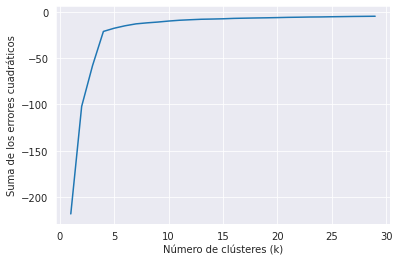

In [0]:
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

La curva elbow nos muestra que un valor de k = 5 puede ser apropiado, aunque se podría probar con valores entre 5 y 10 y comparar resultados. No hay una solución, un valor de k, más correcto que otro, ya que el objetivo de una clusterización con k-means es obtener información útil nuestros datos, por lo que nuestra interpretación a posteriori de los clústeres creados marcará la calidad de nuestra solución escogida.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Observando los centroides de cada cluster. ¿Qué tipos de usuarios describen cada cluster? 
</div>

In [0]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.40432939 0.54162859 0.71093879]
 [0.11329995 0.08032122 0.05008262]
 [0.64888252 0.15175766 0.16899211]
 [0.17023367 0.51330559 0.29418709]
 [0.40988885 0.7571108  0.70779725]]


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>[OPCIONAL] Implementación:</strong> visualiza el dataset en 3 dimensiones, donde los puntos del mismo color pertenezcan al mismo cluster. 
</div>

In [0]:
# Predicting the clusters
X = np.array(df[['avg_month_turnover', 'n_days_per_week', 'n_month_purchases']])
labels = kmeans.predict(df)
# Getting the cluster centers
C = kmeans.cluster_centers_

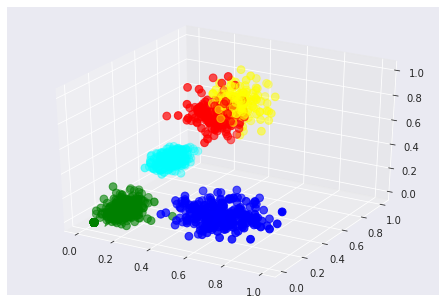

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)


En estas gráficas vemos que están bastante bien diferenciados los grupos.

Podemos ver cada uno de los clusters cuantos clientes tiene:

In [0]:
copy =  pd.DataFrame()
copy['avg_month_turnover']=df['avg_month_turnover'].values
copy['n_days_per_week']=df['n_days_per_week'].values
copy[ 'n_month_purchases']=df['n_month_purchases'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,155
1,green,361
2,blue,239
3,cyan,300
4,yellow,145


De forma **optativa** se plantea **realizar el apartado anterior con una implementación propia del algoritmo *k-means***.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>[OPCIONAL] Implementación:</strong> algoritmo <i>k-means</i> desde cero.  
</div>

In [0]:
#%% Aplicación de k-means con k = 2.
kmeans = KMeans(n_clusters=2).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.32599837 0.10991153 0.09840856]
 [0.28909177 0.58112235 0.50286043]]


In [0]:
# Predicting the clusters
X = np.array(df[['avg_month_turnover', 'n_days_per_week', 'n_month_purchases']])
labels = kmeans.predict(df)
# Getting the cluster centers
C = kmeans.cluster_centers_

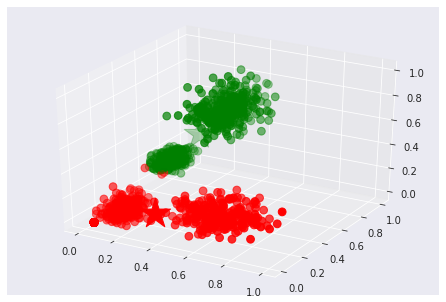

In [0]:
colores=['red','green']
asignar=[]
for row in labels:
    asignar.append(colores[row])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)



En estas gráficas vemos que están bastante bien diferenciados los grupos.

Podemos ver cada uno de los clusters cuantos clientes tiene:

In [0]:
copy2 =  pd.DataFrame()
copy2['avg_month_turnover']=df['avg_month_turnover'].values
copy2['n_days_per_week']=df['n_days_per_week'].values
copy2[ 'n_month_purchases']=df['n_month_purchases'].values
copy2['label'] = labels;
cantidadGrupo2 =  pd.DataFrame()
cantidadGrupo2['color']=colores
cantidadGrupo2['cantidad']=copy.groupby('label').size()
cantidadGrupo2

,color,cantidad
0,red,155
1,green,361


En este caso, con 2 dimensiones, es muy sencillo inferir el número de clusters visualizando los datos. Pero este método es de gran utilidad cuando se cuenta con datos de alta dimensionalidad.

## 2. Clustering con formas y feature engineering (4 puntos)

Pero no todos los datasets son como los del ejercicio anterior. Para esta segunda parte vamos a emplear el siguiente conjunto de datos:

In [0]:
data_circles = ('circles', *datasets.make_circles(n_samples=1000, factor=.5, noise=.05))

Donde *data_circles* es una tupla con tres posiciones: el nombre del dataset y los dos valores devueltos por la función que genera el dataset:

In [0]:
datasets.make_circles?

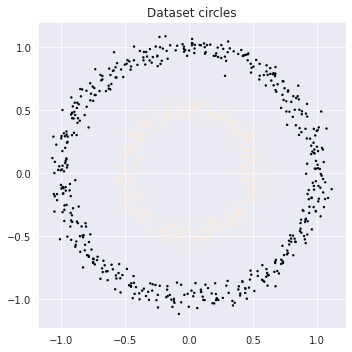

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data_circles[1][:,0], data_circles[1][:,1], c=data_circles[2], s=2)
ax.set_title('Dataset {}'.format(data_circles[0]))
plt.tight_layout()

### 2 a. Encontrando los clusters con *k-means*

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aplica la regla del codo para decidir el valor de $k$.
</div>

In [0]:
df = pd.DataFrame({'circulo 1': data_circles[1][:,0], 'circulo 2': data_circles[1][:,1]})

In [0]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.6522625  -0.28593598]
 [ 0.69116752 -0.13414808]
 [-0.4690722   0.52040571]
 [ 0.07416925 -0.69094962]
 [ 0.3618017   0.61418457]]


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aplica <i>k-means</i> con el valor de $k$ elegido.
<br>
Visualiza el resultado en un <i>scatter plot</i> representando cada cluster con un color distinto.
</div>

In [0]:
# Predicting the clusters
X = np.array(df[['circulo 1', 'circulo 2']])
labels = kmeans.predict(df)
# Getting the cluster centers
C = kmeans.cluster_centers_

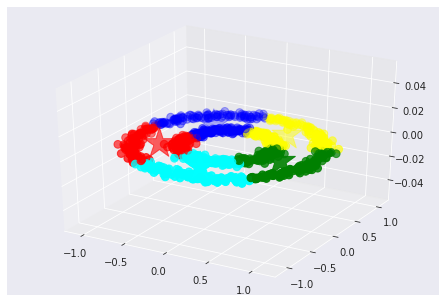

In [0]:
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>



En estas gráficas vemos que están bastante bien diferenciados los grupos.

Podemos ver cada uno de los clusters cuantos clientes tiene:

In [0]:
copy3 =  pd.DataFrame()
copy3['circulo 1']=df['circulo 1'].values
copy3['circulo 2']=df['circulo 2'].values
copy3['label'] = labels;
cantidadGrupo3 =  pd.DataFrame()
cantidadGrupo3['color']=colores
cantidadGrupo3['cantidad']=copy.groupby('label').size()
cantidadGrupo3

,color,cantidad
0,red,155
1,green,361
2,blue,239
3,cyan,300
4,yellow,145


### 2 b. Más allá de K-Means: algoritmos basados en densidad

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) al dataset anterior para poder encontrar los dos clusters iniciales.

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar las 2 estructuras subyacentes (y <i>outliers</i>).
</div>

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
# agrupa los datos en cinco grupos 
dbscan = DBSCAN(eps=0.123, min_samples = 2)
clusters = dbscan.fit_predict(X)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

El parámetro epses algo más importante, ya que determina lo que significa que los puntos estén cerca. Establecer epsun valor muy pequeño significará que ningún punto es una muestra central, y puede hacer que todos los puntos se etiqueten como ruido. Si se configura epscomo muy grande, todos los puntos formarán un solo grupo.

Después de girar epsy min_samplesdurante algún tiempo, obtuve algunos grupos bastante consistentes, que aún incluyen algunos puntos de ruido.
Si bien DBSCAN no requiere establecer el número de clústeres explícitamente, la configuración epscontrola implícitamente cuántos clústeres se encontrarán.
Encontrar una buena configuración epses a veces más fácil después de escalar los datos, ya que el uso de estas técnicas de escalado asegurará que todas las características tengan rangos similares.
Por último, teniendo en cuenta que creamos los puntos de datos que definen explícitamente 5 clústeres, podemos medir el rendimiento utilizando ajustado_y_punto. Esto no es frecuente ya que en casos reales no tenemos etiquetas de clúster para comenzar (por lo tanto, nuestra necesidad de aplicar técnicas de agrupamiento). Como en este caso tenemos etiquetas, podemos medir el rendimiento:

Text(0, 0.5, 'Feature 1')

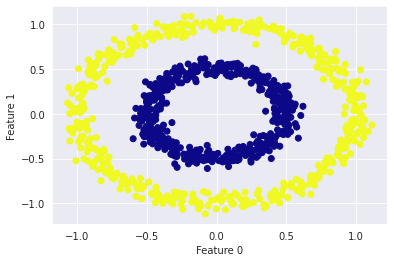

In [0]:
# trazar las asignaciones de clúster 
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### 2 c. Más allá de K-Means: algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los dos clusters.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong><br>

prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permimtiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma.
</div>

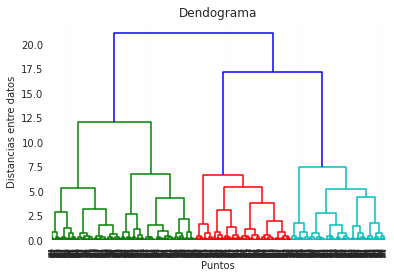

In [0]:
# Creamos el dendograma para encontrar el número óptimo de clusters

import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))

plt.title('Dendograma')
plt.xlabel('Puntos')
plt.ylabel('Distancias entre datos')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

Las líneas verticales del dendrograma ilustran las fusiones (o divisiones) realizadas en cada etapa del clustering. Podemos ver la distancia, los distintos niveles de asociaciones entre los datos individuales y también las asociaciones entre clústers.

In [0]:
# Ajustando Clustering Jerárquico al conjunto de datos
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, 
                    affinity = 'euclidean', 
                    linkage = 'ward')

y_hc = hc.fit_predict(X)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

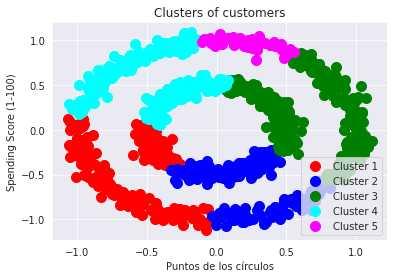

In [0]:
# Visualising the clusters
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('Clusters of customers')
plt.xlabel('Puntos de los círculos')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

En relación a los puntos de los círculos, observamos un grupo de puntos que podría ser de interés. El grupo de datos en color rojo, lo cuales tienen mas puntos en común, por lo que podrían ser un grupo objetivo para ciertas gráficas. En purpura tenemos baja relación, mientras que en azul claro, con altos puntos en común, lo cual podría indicar que estos puntos tienen alguna relación. Es decir, el análisis cluster permite hacer inferencias y tomar decisiones de los datos.

### 2 d. *Feature engineering* y agrupamiento

Algunos de los algoritmos anteriores se basan en unas suposiciones que no cumplían en el dataset.
Muchas veces en lugar de optar por algoritmos más complejos o que requieren mayor cómputo, se pueden transformar los datos para poder aplicar con éxito técnicas más simples. Esto es un claro ejemplo de *feature engineering*.

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> transforma los puntos anteriores del dataset a un nuevo espacio de 2 dimensiones:
<ul>
<li>Radio, o distancia al punto (0,0)
<li>Ángulo,con respecto al vector (1,0)
</ul>
Para que todas las dimensiones tengan el mismo peso, además vamos a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">normalizarlas entre 0 y 1 de acuerdo a su máximo y mínimo</a>.
<br>
Visualizar los puntos del "nuevo" dataset.
</div>

Text(0, 0.5, 'Feature 1')

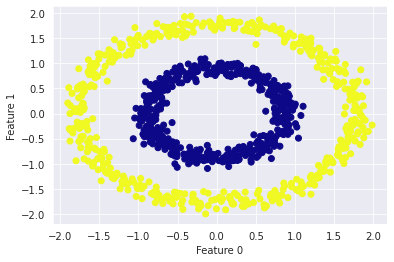

In [0]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_pred = kmeans.predict(X_scaled)
# trazar las asignaciones de clúster 
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué crees que sucederá al aplicar los anteriores algoritmos en este "nuevo" dataset?
</div>

In [0]:
#%% Aplicación de k-means con k = 2.
kmeans = KMeans(n_clusters=2).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 0.41370885  0.24652565]
 [-0.41311071 -0.24115946]]


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aplica cada uno de los algoritmos de agrupamimento anteriores que no hayan podido localizar adecuadamente los dos clusters originales para tratar de encontrarlos en este "nuevo" espacio. Ajusta los parámetros necesarios para facilitar su detección.
<br><br>
Para cada algoritmo, visualiza los clusters encontrados en 2 imágenes:
<ul>
<li> En el "nuevo" espacio (radio y ángulo).
<li> En el espacio original (posición x e y), pero NO con las etiquetas (pertenencia al cluster) obtenidas al aplicar los algoritmos sobre el dataset original, sino con las etiquetas obtenidas al realizar el clustering en el "nuevo" espacio. A ver si así se consiguen solventar los problemas iniciales.
</ul>
</div>

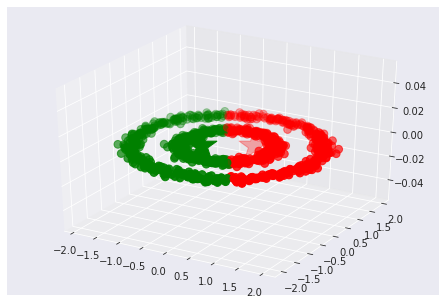

In [0]:
colores=['red','green']
asignar=[]
labels = kmeans.predict(df)
# Getting the cluster centers
C = kmeans.cluster_centers_
for row in labels:
    asignar.append(colores[row])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)

## 3. Aplicación para comprimir imágenes (2 puntos)

Las imágenes en color se componen de píxeles que tienen tres componentes (roja, azul y verde), destinando 1 *byte* a cada canal. Pudiendo representar $2^8 = 256$ rojos, verdes y azules. Con un total de $2^{8^{3}} = 2^{24} = 16777216$ colores representables en cada píxel.

Entre mayor sea el número de colores representables, más memoria será necesaria para almacenar la imagen.
Por tanto, una estrategia para comprimir una imagen puede ser disminuir los colores representables en cada píxel, necesitando menos *bits* para guardar el valor de un píxel. Este método no es reversible, es decir, no se puede volver a recuperar la imagen original a partir de la comprimida. Por tanto, este tipo de compresiónse denomina [comprensión con pérdidas](https://es.wikipedia.org/wiki/Algoritmo_de_compresi%C3%B3n_con_p%C3%A9rdida).

Pero ¿cómo seleccionamos los "píxeles parecidos" en la imagen original y determinamos su color en la imagen comprimida?. Una opción es utilizar *k-means* donde **$k$ será el número de colores representables**, los puntos que pertenecen a cada cluster equivaldrían a los "píxeles parecidos" y las coordenadas de los **centroides actuarán como los colores finales** a los que se aproximarán los "píxeles parecidos".

Como resultado del clustering, se obtiene una paleta de colores reducida (coordenadas de los centroides) donde cada píxel de la imagen hará referencia a uno de estos colores (cluster al que pertenece). El uso de paletas de colores o [colores indexados](https://en.wikipedia.org/wiki/Indexed_color) es un recurso empleado por distintos formatos de imagen como *PNG*, *GIF* o *TIFF*.

Si no dispones de la librería ``skimage`` puedes instalarla:
 - Usando conda (si has creado tu entorno virtual con conda): ``conda install scikit-image``
 - Usando pip: ``pip install scikit-image``

Imagen con 65536 pixeles (196608 bytes)


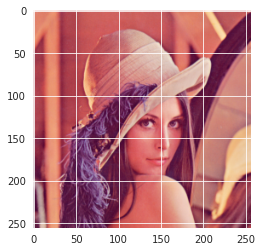

In [0]:
from skimage import io, transform

photo = (transform.resize(
    io.imread('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'),
    (256, 256), mode='edge') * 255).astype(np.uint8)
plt.imshow(photo)       
X = photo.reshape(-1, 3) 
print('Imagen con {} pixeles ({} bytes)'.format(X.shape[0], X.shape[0] * 3))

Para facilitar la tarea, la imagen anterior está guardada en un *array* con tantas filas como píxeles y columnas como canales (rojo, verde y azul). De forma que cada "muestra" equivale al valor de un píxel.

Se puede volver a recomponer la imagen original con:
```
plt.imshow(X.reshape(photo.shape))
```
Podemos ver cada píxel como un punto en un sistema de coordenadas de 3 dimensiones donde una es su cantidad de rojo, otra su cantidad de verde y por último su cantidad de azul. Por lo que podemos realizar una visualización en 3 dimensiones de los píxeles sobre la que se probará el algoritmo de clustering:

In [0]:
X

array([[224, 136, 125],
       [223, 136, 128],
       [224, 132, 118],
       ...,
       [165,  68,  82],
       [175,  67,  78],
       [181,  70,  79]], dtype=uint8)

Para visualizar la animación de la representación 3D de los píxeles es necesario instalar la librería ``ffmpeg``.

Si tienes un entorno virtual de conda, lo puedes instalar con: ``conda install -c conda-forge ffmpeg``.

**Si tienes un error**, puedes ver una representación estática 2 celdas más adelante.

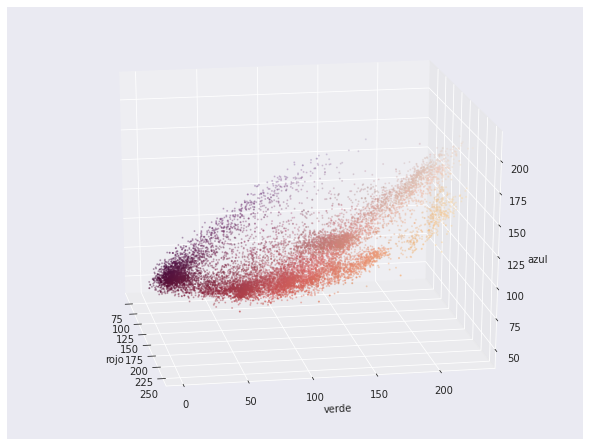

In [0]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['animation.html'] = 'html5'

idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .2))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')

def animate(i):
    ax.view_init(elev=20., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, frames=range(0, 360, 10), interval=200, blit=True)
anim

Visualización estática del valor de los píxeles:

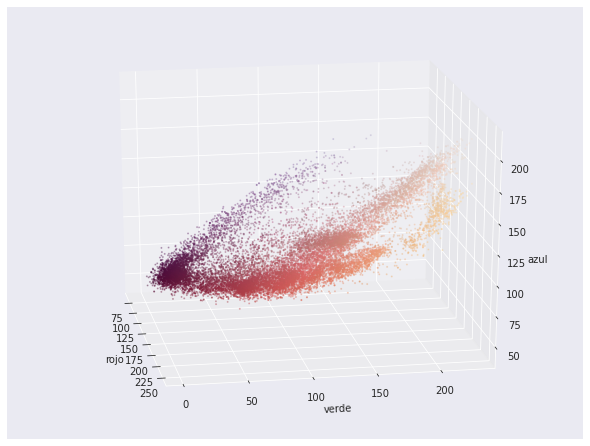

In [0]:
idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .3))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')
ax.view_init(20, 350)
plt.show()

En la visualización anterior se ha representado cada píxel con su color, donde sus coordenadas en los 3 colores oscilan entre 0 (carece de esa componente) y 1. Podemos comprobar como los píxeles en coordenadas (255, 255, 255) son píxeles blancos y los situados en (0, 0, 0) son píxeles negros. También se observan 4 estructuras de píxeles: la pluma del sombrero, el sombrero, la piel de la modelo (Lenna) y el fondo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Aplicar <i>k-means</i> con <i>k=3</i> a los píxeles de la imagen (puntos con 3 dimensiones de la variable <i>X</i>) y obtener, para cada punto, su centroide más cercano. Y las coordenadas (3 dimensiones) de cada centroide.
</div>

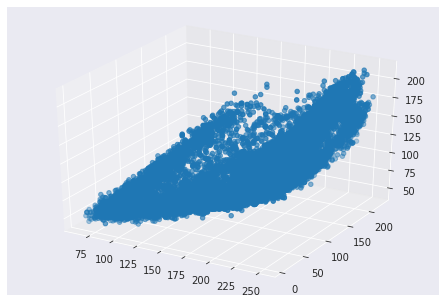

In [0]:
r = X[idx,0]
g = X[idx,1]
b =  X[idx,2]

#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

In [0]:
# Number of clusters
k = 3
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_B = np.random.randint(0, np.max(X)-20, size=k)
C = np.array(list(zip(C_R,C_G,C_B)), dtype=np.float32)
print(C)

[[  8.  42. 112.]
 [150. 139. 128.]
 [166. 143. 120.]]


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> asgina a cada punto (píxel de la imagen) el valor de su centroide asociado en lugar de su propio valor.
</div>

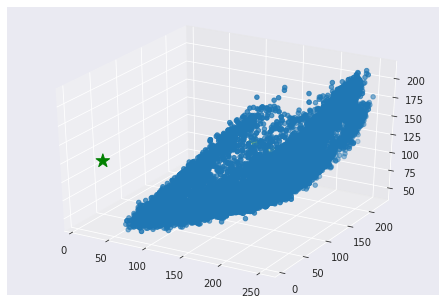

In [0]:
# Plotting along with the Centroids
#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
ax.scatter(C_R,C_G, C_B, marker='*', s=200, c='g')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> volver a convertir el resultado en una imagen usando la función <i>reshape</i> (como cuando se creó X) para que vuelva a tener su dimensión de <i>256 x 256</i>. Y mostrarla con <i>imshow</i>.
</div>

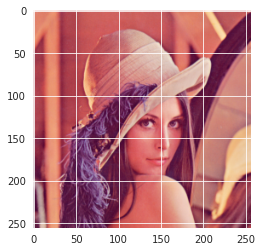

In [0]:
plt.imshow(X.reshape(photo.shape))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿por qué se ha producido este resultado? ¿qué relación tiene con el clústering?


</div>

In [0]:
# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

# Comparing with scikit-learn centroids
print("Centroid values")
print("Scratch")
print(C) # From Scratch
print("sklearn")
print(centroids) # From sci-kit learn

Centroid values
Scratch
[[  8.  42. 112.]
 [150. 139. 128.]
 [166. 143. 120.]]
sklearn
[[193.63661122  96.43084949  99.49860551]
 [109.62712912  34.59486199  71.8993198 ]
 [223.64655472 164.40306891 144.68928778]]


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> realizar el proceso anterior para distintos valores de <i>k</i>: 256, 128, 64, 32, 16, 8, 4 y 2 colores. Mostrar las imágenes e indicar los bytes que ocuparía cada una de las opciones.
</div>

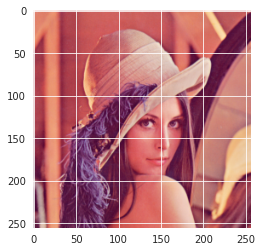

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 256
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

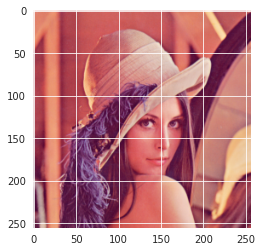

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 128
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

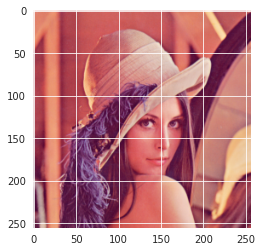

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 64
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

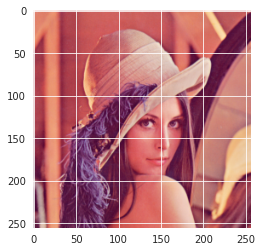

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 32
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

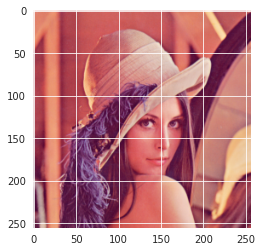

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 16
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

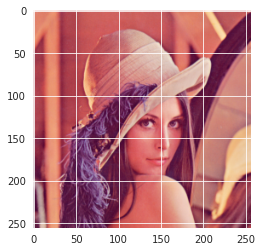

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 8
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

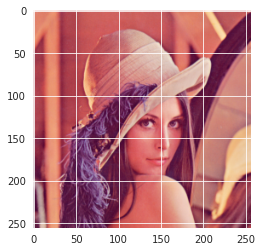

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 4
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

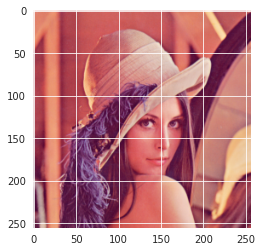

In [0]:
r = X[idx,0]
g = X[idx,1]
# Number of clusters
k = 2
# X coordinates of random centroids
C_R = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_G = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C = np.array(list(zip(C_R,C_G)), dtype=np.float32)
plt.imshow(X.reshape(photo.shape))

Todos ocupan el mismo número de bits 65536

## 4. Aplicación de reducción de dimensionalidad para resolver un problema de optimización: t-SNE (2 punto)

Como ya se ha visto, el algoritmo [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ideado por [van der Maaten y Hinton](https://lvdmaaten.github.io/tsne/) difiere de PCA en que no trata de maximizar la varianza explicada. Intuitivamente, t-SNE trata de que la vecindad de un punto en baja dimensionalidad sea la misma que la original (mantenga las distancias). Partiendo de una localización aleatoria de cada punto, corrige su posición de forma iterativa tratando de minimizar la distancia a sus vecinos originales hasta converger.

Para ello, t-SNE dispone de diversos [parámetros](https://distill.pub/2016/misread-tsne/) que pueden modificar drásticamente el resultado. Por lo que se recomienda conocer su funcionamiento antes de aplicar la técnica.

Partiendo de las distancias entre las [provincias de la península ibérica](https://www.gifex.com/images/0X0/2009-12-02-11305/Provincias_de_Espana.jpg), presentes en el fichero de datos (en *pec2_2.p* un *DataFrame* de *pandas* en formato *pickle* o *pec2_2.csv* en formato *CSV*). Se pide calcular la matriz cuadrada que contenga la distancia de cada provincia contra las demás.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> la matriz debe tener tantas filas y columnas como provincias. Y cada celda debe contener la distancia entre las provincias de esa fila y columna.
</div>

In [0]:
#Para la lectura de los archivos he 
url="https://glass.artwebserver.net/data_csv/pec2_2.csv"
data=pd.read_csv(url)
data.head()



,from,to,dist
0,A Coruña,A Coruña,0.000000
1,A Coruña,Albacete,724.856651
2,A Coruña,Alicante/Alacant,846.212163
3,A Coruña,Almería,840.615943
4,A Coruña,Asturias,203.994866


In [0]:
#Calculo estadísticos descriptivos básicos: media, mediana, desviación estandard
data.describe() #esto me entrega estadísticas generales de las columnas

,dist
count,2500.000000
mean,424.075751
std,215.311583
min,0.000000
25%,256.652783
50%,410.076099
75%,578.608356
max,1026.929115


In [0]:
#Frecuencia de la variable distancia
data.dist.value_counts()

0.000000      45
0.000095       4
96.461959      2
281.765232     2
265.019803     2
              ..
576.079382     2
829.267344     2
714.013725     2
364.545939     2
0.000134       1
Name: dist, Length: 1228, dtype: int64

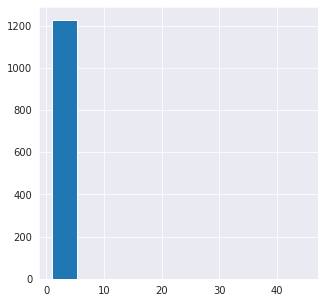

In [0]:
#Explorando los datos
data.dist.value_counts().hist(figsize=(5, 5))
plt.show()

Una vez que se cuenta con la matriz de distancias, *t-SNE* tratará de mantener esas distancias entre los distintos puntos en baja dimensionalidad (en este caso 2 dimensiones). Emplazando los puntos en el plano mientras intenta mantener las distancias indicadas.

Dado que la entrada a [*t-SNE*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) se le pasa la matriz de distancias, no es necesario que las calcule. Por ello le indicaremos que la métrica a emplear es "precalculada".

Como *t-SNE* es un algoritmo estocástico (dos ejecuciones consecutivas con los mismos datos pueden conducir a resultados diferentes). Se pide realizar el proceso de ajuste con *t-SNE* 100 veces y quedarse con la ejecución con menor error (ver el atributo [*kl_divergence*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> jugar con los hiperparámetros de <i>t-SNE</i>, ejecutar 100 veces el ajuste de <i>t-SNE</i> y guardar el resultado de emplazamiento de provincias en el plano de la ejecución con menor error.
</div>

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# Invoke the TSNE method
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(x)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.175053
[t-SNE] KL divergence after 2000 iterations: 0.221640


Una vez que se tienen las posiciones de las provincias en el plano, visualizar el resultado y analizar si el emplazamiento de las provincias calculado por *t-SNE* calculado en base a las distancias se parece al real.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> visualizar en un <i>scatter</i> las provincias de la ejecución con menor error, junto con su nombre para poder analizarlo.
</div>

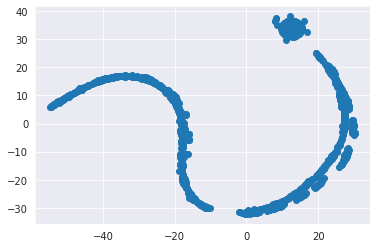

In [0]:
plt.scatter(tsne_results[50:,0] , tsne_results[50:,1])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿se parece a la distribución de provincias real? ¿por qué?
</div>

No se a parece a la distribución normal porque es una muestra mucho más detallada. El ajuste de hiperparámetros puede ser ventajoso para crear un modelo que sea mejor en la clasificación. 

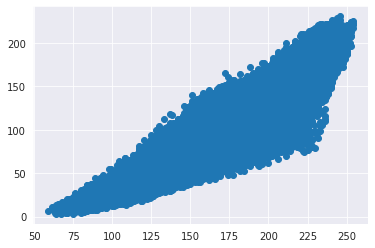

In [0]:
plt.scatter(X[50:,0] , X[50:,1])